## Phase 1: Data Ingestion & Clinical Sanitation

### Objective
Transform raw, error-prone clinical encounter data into a reliable analytical dataset suitable for downstream analysis and modeling.

### Rationale

Clinical databases are inherently messy due to:
- Non-standard representations of missing values
- Legacy coding systems
- Data entry errors
- Administrative outcomes (e.g., death) that invalidate predictive targets

This phase establishes a **clean analytical baseline** by enforcing consistent null handling, removing structurally invalid records, and stabilizing categorical identifiers.

### Key Decisions

1. **Standardizing Missing Values**
   - The dataset uses `'?'` to represent missing values.
   - These are converted to NumPy `NaN` to enable proper statistical handling.

2. **Dropping the `weight` Column**
   - The `weight` feature exhibits >90% missingness.
   - Imputation would be statistically meaningless and introduce bias.
   - This limitation is documented as a data quality constraint.

3. **Handling Invalid Gender Values**
   - `Unknown/Invalid` is treated as missing, not as a valid category.

4. **Removing Deceased Patients**
   - Patients who expire or enter hospice cannot be readmitted.
   - Including them would inject label noise into readmission analysis.
   - Discharge disposition codes corresponding to death/hospice are identified via `IDs_mapping.csv`.

5. **Deduplication**
   - Exact duplicate rows indicate data entry or ETL errors and are removed.

6. **Stabilizing Categorical Identifiers**
   - Administrative ID columns are cast to strings to prevent numerical misinterpretation.

The output of this phase is a **sanitized encounter-level dataset**, persisted to disk for reproducibility.

In [7]:
print("\n--- IMPORTING LIBRARIES ---")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import os

# Configuration to display all columns
pd.set_option('display.max_columns', None)


--- IMPORTING LIBRARIES ---


In [ ]:
print("\n--- STARTING PHASE 1: DATA INGESTION & CLINICAL SANITATION ---")

def load_and_sanitize_data(data_path, id_map_path):
    """
    Phase 1 sanitation pipeline:
    - Standardize missing values
    - Audit schema
    - Drop structurally invalid features
    - Remove deceased patient encounters
    - Deduplicate exact duplicates
    - Stabilize categorical identifiers
    """

    # 1. Ingest Data & Standardize Missing Values
    df = pd.read_csv(data_path, na_values='?')
    print(f"Dataset loaded. Initial shape: {df.shape}")

    # 2. Initial Audit (Schema & Data Types)
    print("\n--- SCHEMA OVERVIEW ---")
    df.info()

    print("\n--- NUMERICAL SUMMARY ---")
    print(df.describe())

    print("\n--- COLUMN SCHEMA ---")
    print(df.columns.tolist())

    # 3. Drop Weight Column (>90% Missingness)
    if 'weight' in df.columns:
        missing_rate = df['weight'].isna().mean()
        print(f"\nWeight missingness: {missing_rate:.2%}")

        if missing_rate > 0.90:
            df = df.drop(columns=['weight'])
            print("Dropped 'weight' due to excessive missingness (>90%).")

    # 4. Handle Invalid Gender Values
    if 'gender' in df.columns:
        invalid_count = (df['gender'] == 'Unknown/Invalid').sum()
        df.loc[df['gender'] == 'Unknown/Invalid', 'gender'] = np.nan
        print(f"Converted {invalid_count} invalid gender entries to NaN.")

    # 5. Remove Deceased / Hospice Patients
    id_map = pd.read_csv(id_map_path, header=None, names=['id', 'description'])

    # Extract discharge disposition section from semi-structured mapping file
    start = id_map[id_map['id'] == 'discharge_disposition_id'].index[0] + 1
    end = id_map[id_map['id'] == 'admission_source_id'].index[0]

    discharge_map = id_map.iloc[start:end].copy()
    discharge_map['id'] = pd.to_numeric(discharge_map['id'], errors='coerce')

    # Identify expired or hospice-related codes
    expired_codes = discharge_map[
        discharge_map['description'].str.contains('Expired|Hospice', case=False, na=False)
    ]['id'].tolist()

    before_filter = len(df)
    df = df[~df['discharge_disposition_id'].isin(expired_codes)]
    print(f"Removed {before_filter - len(df)} deceased/hospice encounters.")

    # 6. Deduplication (Exact Row Matches)
    before_dedup = len(df)
    df = df.drop_duplicates()
    print(f"Removed {before_dedup - len(df)} exact duplicate rows.")

    # 7. Stabilize Administrative Categorical IDs
    categorical_ids = [
        'admission_type_id',
        'discharge_disposition_id',
        'admission_source_id'
    ]

    for col in categorical_ids:
        if col in df.columns:
            df[col] = df[col].astype(str)

    print(f"\nPhase 1 complete. Final dataset shape: {df.shape}")
    return df

# EXECUTION
DATA_PATH = "../data/raw/diabetic_data.csv"
ID_MAP_PATH = "../data/raw/IDs_mapping.csv"
OUTPUT_PATH = "../data/processed/diabetic_data_phase1_clean.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Raw dataset not found. Check path.")

# Run sanitation
df_phase1 = load_and_sanitize_data(DATA_PATH, ID_MAP_PATH)

print("\n--- CLEAN DATA PREVIEW ---")
display(df_phase1.head())

# Persist cleaned dataset
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
df_phase1.to_csv(OUTPUT_PATH, index=False)

print(f"\n✓ Phase 1 cleaned data saved to: {OUTPUT_PATH}")


--- STARTING PHASE 1: DATA INGESTION & CLINICAL SANITATION ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\395609283.py:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, na_values='?')


Dataset loaded. Initial shape: (101766, 50)

--- SCHEMA OVERVIEW ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  in

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO



✓ Phase 1 cleaned data saved to: ../data/processed/diabetic_data_phase1_clean.csv


## Phase 2: Data Enrichment via Web Scraping (ICD-9)

### Objective
Translate cryptic ICD-9 primary diagnosis codes into clinically meaningful disease descriptions to improve interpretability for non-technical stakeholders.

### Rationale

The `diag_1` column contains ICD-9 diagnosis codes (e.g., `428`, `250.02`) that are meaningful to clinicians but opaque to decision-makers.
Rather than scraping the full ICD-9 catalog, only the **top 20 most frequent diagnoses** are enriched to balance interpretability, efficiency, and ethical scraping practices.

### Methodology

1. **Target Selection**
   - Identify the top 20 most frequent `diag_1` codes.

2. **Web Scraping**
   - Use `icd9.chrisendres.com` as a public ICD-9 lookup resource.
   - Normalize integer codes to 3-digit format (e.g., `38 → 038`).
   - Preserve decimal codes without modification (e.g., `250.02`).
   - Validate scraped results to avoid incorrect mappings.
   - Introduce a 1-second delay between requests.

3. **Integration**
   - Create a new column `Primary_Diagnosis_Desc`.
   - Codes outside the top 20 are labeled as `"Not in Top 20"`.

The enriched dataset is persisted as a new Phase 2 artifact to preserve reproducibility.

In [3]:
print("\n--- STARTING PHASE 2: ICD-9 DATA ENRICHMENT ---")

# Helper: Fetch ICD-9 Description (Validated)
def fetch_icd9_description(icd_code):
    """
    Fetch ICD-9 long description from icd9.chrisendres.com.
    Returns a validated disease description or a failure label.
    """

    BASE_URL = "http://icd9.chrisendres.com/index.php"
    params = {
        "srchtype": "diseases",
        "srchtext": icd_code,
        "Submit": "Search",
        "action": "search"
    }

    try:
        response = requests.get(
            BASE_URL,
            params=params,
            headers={"User-Agent": "Mozilla/5.0"},
            timeout=10
        )

        if response.status_code != 200:
            return "Lookup Failed"

        soup = BeautifulSoup(response.text, "html.parser")
        result_div = soup.find("div", class_="dlvl")

        if not result_div:
            return "Description Not Found"

        text = result_div.text.strip()
        parts = text.split(" ", 1)

        # Validate that returned ICD code matches the query
        if len(parts) == 2 and parts[0].replace(".", "") == icd_code.replace(".", ""):
            return parts[1]

        return "Description Mismatch"

    except Exception:
        return "Lookup Error"

# Main Enrichment Function
def enrich_primary_diagnosis(df, top_n=20):
    """
    Enrich top N ICD-9 primary diagnosis codes with scraped descriptions.
    """

    print(f"\nIdentifying top {top_n} primary diagnosis codes...")
    top_codes = df["diag_1"].value_counts().head(top_n).index.tolist()

    icd_mapping = {}

    for code in top_codes:

        if pd.isna(code):
            icd_mapping[code] = "Administrative / Missing"
            continue

        code_str = str(code)

        # Normalize ICD-9 format:
        # - Integer codes → zero-padded to 3 digits (e.g., 38 → 038)
        # - Decimal codes → left unchanged (e.g., 250.02)
        if code_str.isdigit():
            search_code = code_str.zfill(3)
        else:
            search_code = code_str

        description = fetch_icd9_description(search_code)
        icd_mapping[code] = description

        print(f"Scraped ICD-9 {search_code} → {description}")

        # Ethical scraping delay
        time.sleep(1)

    # Map descriptions to full dataset
    df["Primary_Diagnosis_Desc"] = (
        df["diag_1"]
        .map(icd_mapping)
        .fillna("Not in Top 20")
    )

    return df

# EXECUTION
PHASE1_PATH = "../data/processed/diabetic_data_phase1_clean.csv"
PHASE2_PATH = "../data/processed/diabetic_data_phase2_enriched.csv"

if not os.path.exists(PHASE1_PATH):
    raise FileNotFoundError("Phase 1 dataset not found. Run Phase 1 first.")

df = pd.read_csv(PHASE1_PATH)

df = enrich_primary_diagnosis(df, top_n=20)

print("\n--- ENRICHED DIAGNOSIS PREVIEW ---")
display(df[["diag_1", "Primary_Diagnosis_Desc"]].head(15))

# Persist Phase 2 output
df.to_csv(PHASE2_PATH, index=False)
print(f"\n✓ Phase 2 complete. Enriched data saved to: {PHASE2_PATH}")



--- STARTING PHASE 2: ICD-9 DATA ENRICHMENT ---

Identifying top 20 primary diagnosis codes...

C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\4264674574.py:98: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PHASE1_PATH)



Scraped ICD-9 428 → Heart failure
Scraped ICD-9 414 → Other forms of chronic ischemic heart disease
Scraped ICD-9 786 → Symptoms involving respiratory system and other chest symptoms
Scraped ICD-9 410 → Acute myocardial infarction
Scraped ICD-9 486 → Pneumonia, organism unspecified
Scraped ICD-9 427 → Cardiac dysrhythmias
Scraped ICD-9 491 → Chronic bronchitis
Scraped ICD-9 715 → Osteoarthrosis and allied disorders
Scraped ICD-9 682 → Other cellulitis and abscess
Scraped ICD-9 780 → General symptoms
Scraped ICD-9 996 → Complications peculiar to certain specified procedures
Scraped ICD-9 434 → Occlusion of cerebral arteries
Scraped ICD-9 276 → Disorders of fluid, electrolyte, and acid-base balance
Scraped ICD-9 250.8 → Diabetes with other specified manifestations
Scraped ICD-9 599 → Other disorders of urethra and urinary tract
Scraped ICD-9 038 → Septicemia
Scraped ICD-9 584 → Acute renal failure
Scraped ICD-9 V57 → Care involving use of rehabilitation procedures
Scraped ICD-9 250.6 → 

,diag_1,Primary_Diagnosis_Desc
0,250.83,Not in Top 20
1,276,"Disorders of fluid, electrolyte, and acid-base..."
2,648,Not in Top 20
3,8,Not in Top 20
4,197,Not in Top 20
5,414,Other forms of chronic ischemic heart disease
6,414,Other forms of chronic ischemic heart disease
7,428,Heart failure
8,398,Not in Top 20
9,434,Occlusion of cerebral arteries



✓ Phase 2 complete. Enriched data saved to: ../data/processed/diabetic_data_phase2_enriched.csv


## Phase 3: Exploratory Data Analysis (EDA)

### Objective
To uncover patterns, disparities, and operational signals associated with hospital readmissions
before proceeding to feature engineering or modeling.

### Why EDA Matters in Clinical Analytics
Clinical datasets often encode severity, care quality, and systemic bias indirectly.
Exploratory analysis helps validate assumptions, detect class imbalance, and identify
high-risk subgroups that influence downstream model behavior.

### 1. Readmission Landscape
The target variable (`readmitted`) is analyzed to assess class imbalance.
Patients readmitted within 30 days (`<30`) represent the HRRP penalty group
and typically form a minority class, which has implications for model evaluation
(e.g., accuracy is insufficient; recall and precision become more important).

### 2. Demographic Profiling
- **Age Distribution** reveals whether diabetes-related hospitalizations are concentrated
  among older patients.
- **Race × Gender Analysis** evaluates intersectional disparities in readmission risk,
  highlighting potential inequities in care outcomes.

### 3. Medication Efficacy Analysis
- Patients are categorized into **Insulin**, **Oral Medication**, or **No Medication** groups.
  Insulin usage is treated as a proxy for disease severity.
- Medication changes during admission are analyzed as a signal of clinical instability,
  which may correlate with higher readmission risk.

### 4. Operational Metrics
- Length of stay and lab utilization are examined for correlation with readmission.
- A correlation heatmap identifies multicollinearity among clinical workload indicators.
- Discharge disposition is analyzed to compare outcomes for patients discharged
  to **Home** versus **Skilled Nursing Facilities (SNF)**.

All visual outputs are saved as static artifacts to ensure reproducibility and auditability.


--- STARTING PHASE 3: EXPLORATORY DATA ANALYSIS (EDA) ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\3966958030.py:24: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)
C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\3966958030.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


Dataset loaded successfully: (99343, 50)
--- 1. Readmission Landscape ---
--- 1.1 Readmission Distribution ---


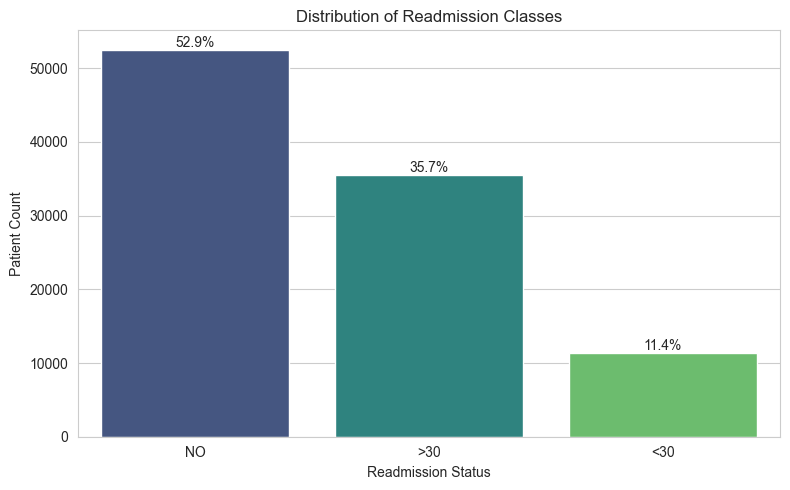

--- 2. Demographic Profiling ---
--- 2.1 Age Distribution ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\3966958030.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="age", data=df, palette="coolwarm")


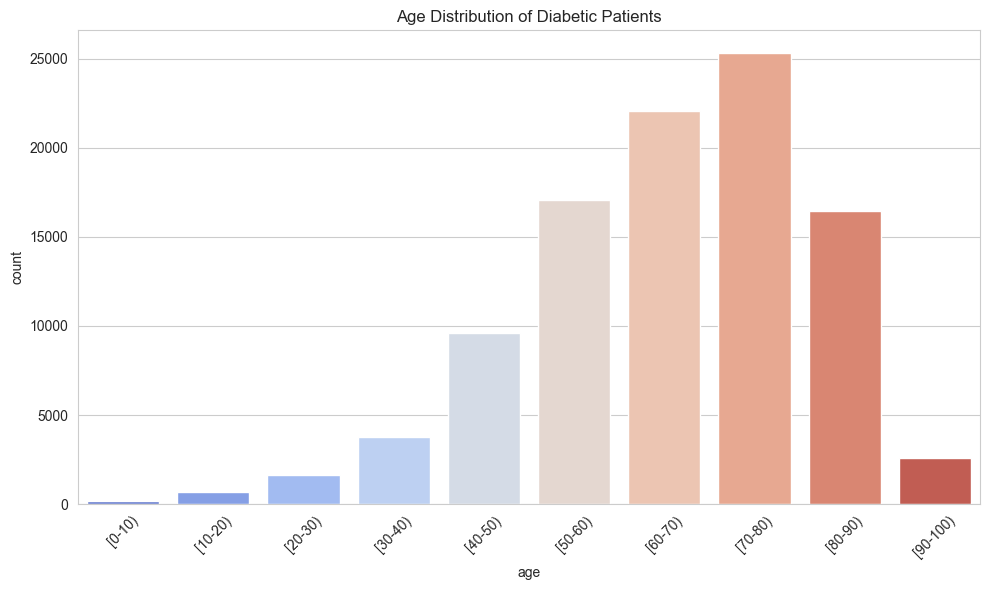

--- 2.2 Readmission Rate by Race and Gender ---


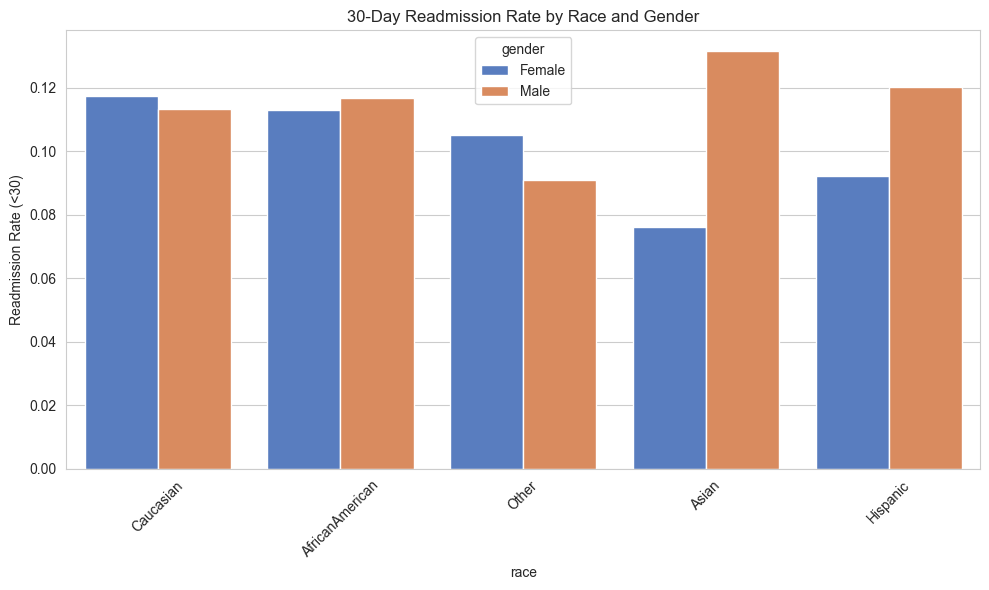

--- 3. Medication Efficacy Analysis ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\3966958030.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


--- 3.1 Readmission Risk by Medication Type ---


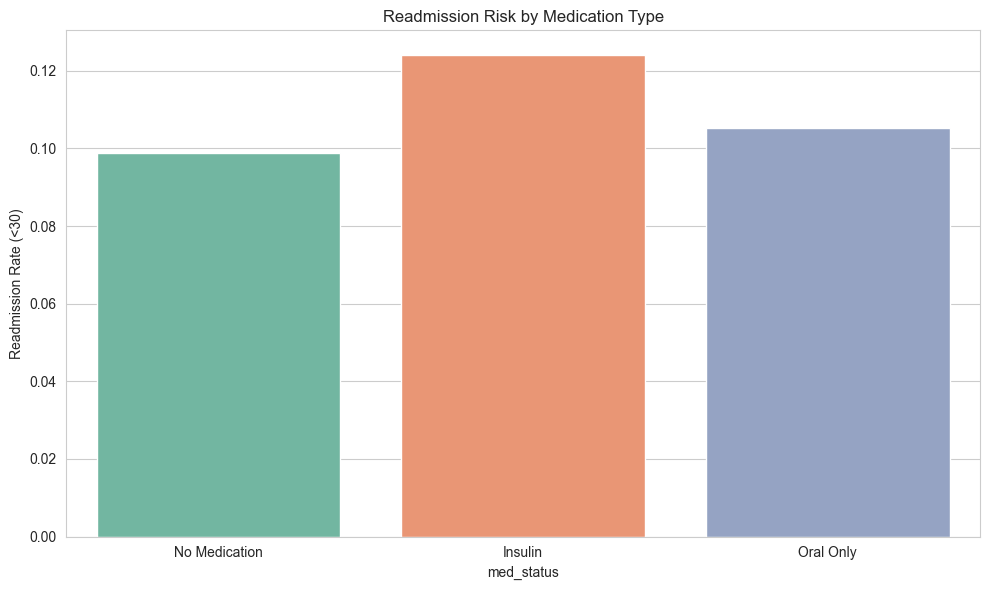

C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\3966958030.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


--- 3.2 Readmission Risk by Medication Change ---


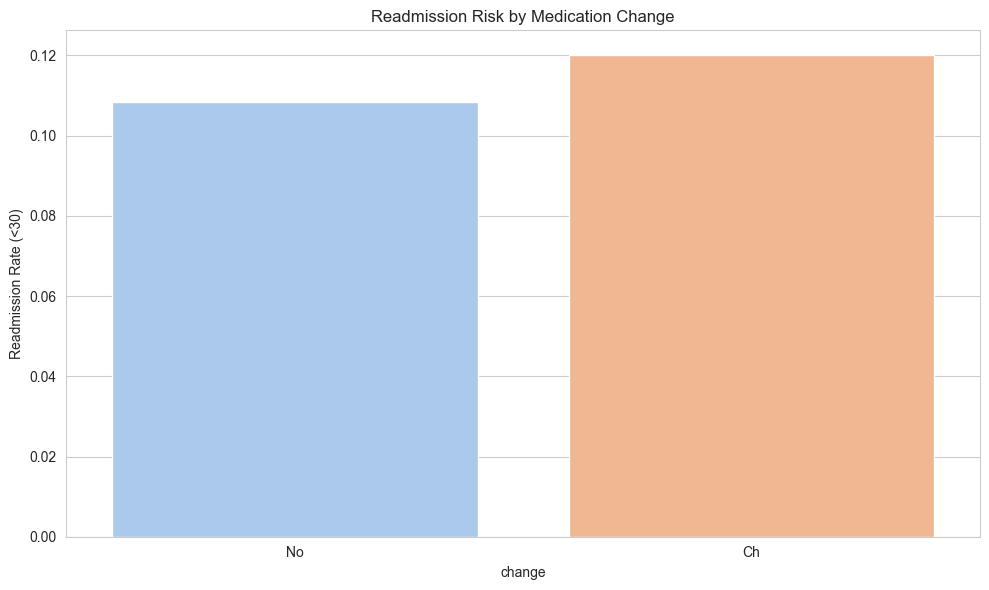

--- 4. Operational Metrics ---
--- 4.1 Hospital Stay vs Lab Utilization ---


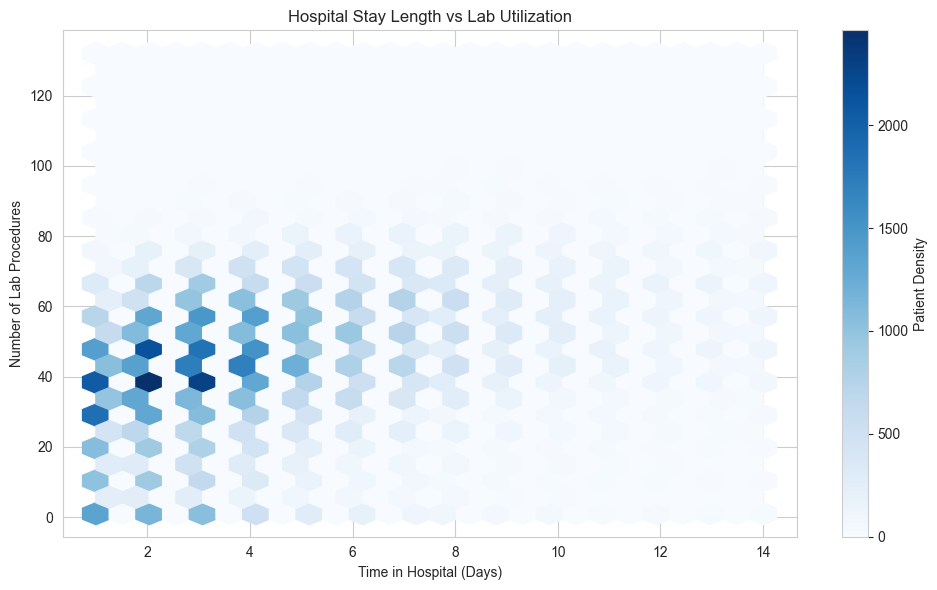

--- 4.2 Clinical Metrics Correlation ---


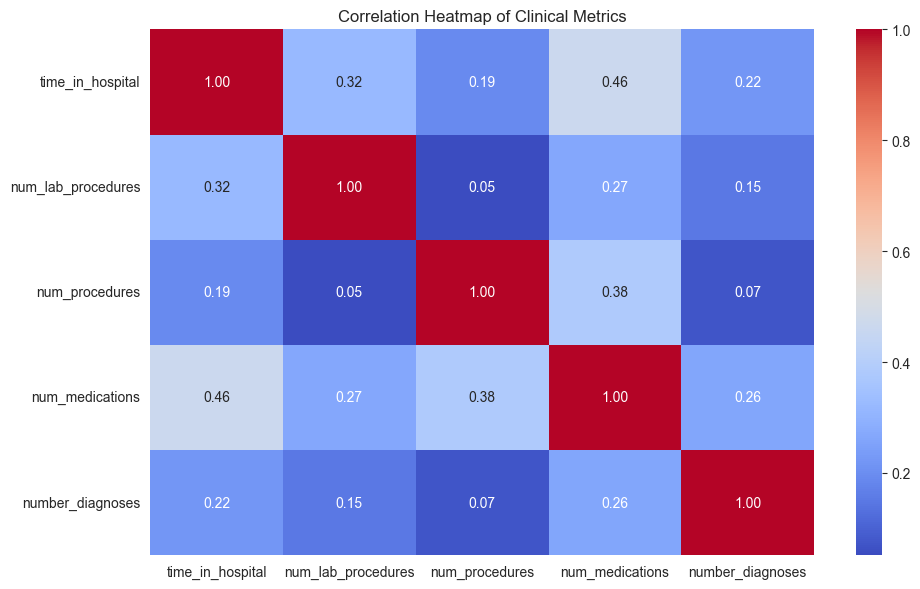

C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\3966958030.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


--- 4.3 Length of Stay by Readmission Outcome ---


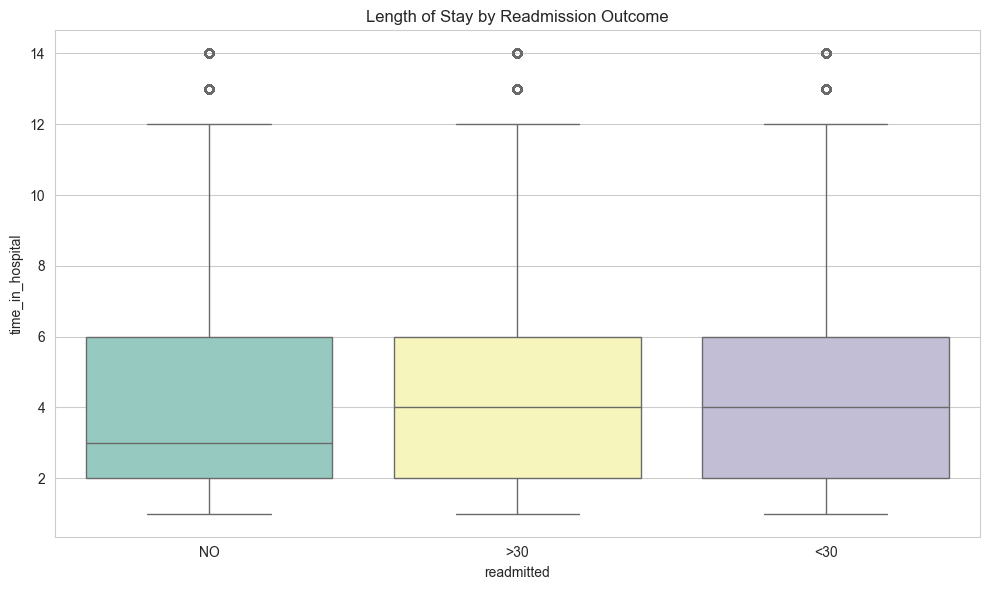

C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\3966958030.py:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


--- 4.4 Readmission by Discharge Location ---


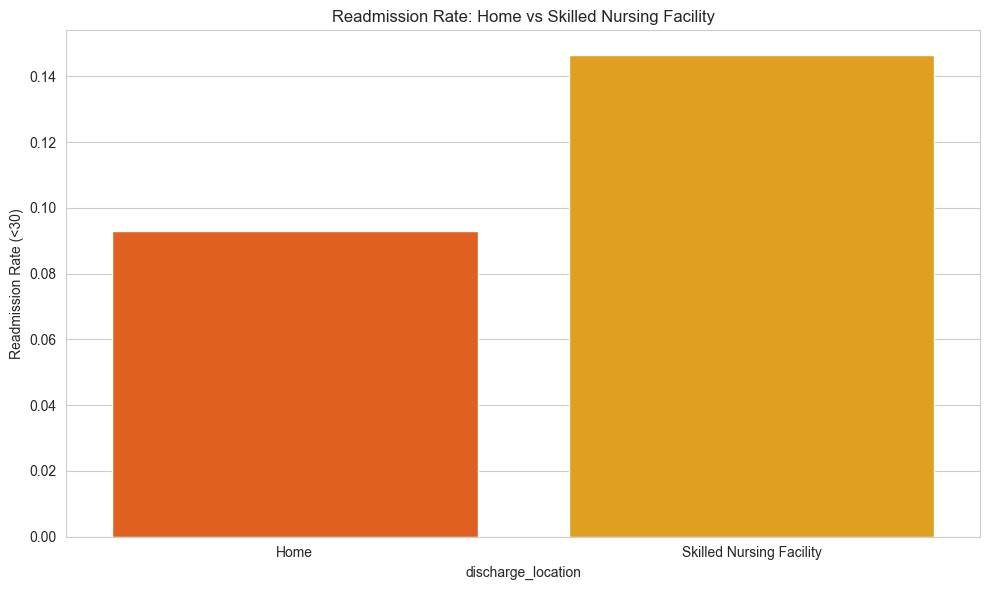


✓ Phase 3 complete. All EDA figures saved to the reports/ directory.


In [4]:
print("\n--- STARTING PHASE 3: EXPLORATORY DATA ANALYSIS (EDA) ---")

# Global Visualization Settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Output directory for figures
REPORTS_DIR = "../reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

def save_and_show(filename):
    """Save current figure to reports directory and display it."""
    path = os.path.join(REPORTS_DIR, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()

# Load Enriched Dataset
DATA_PATH = "../data/processed/diabetic_data_phase2_enriched.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Phase 2 dataset not found. Run Phase 1 and Phase 2 first.")

df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded successfully: {df.shape}")

# Binary target: 30-day readmission
df["target"] = (df["readmitted"] == "<30").astype(int)

# Safely coerce discharge disposition
df["discharge_disposition_id"] = pd.to_numeric(
    df["discharge_disposition_id"], errors="coerce"
)

# 1. Readmission Landscape
print("--- 1. Readmission Landscape ---")

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x="readmitted",
    data=df,
    order=["NO", ">30", "<30"],
    palette="viridis"
)

plt.title("Distribution of Readmission Classes")
plt.xlabel("Readmission Status")
plt.ylabel("Patient Count")

for p in ax.patches:
    ax.annotate(
        f"{p.get_height() / len(df) * 100:.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom"
    )

print("--- 1.1 Readmission Distribution ---")
save_and_show("1_readmission_distribution.png")

# 2. Demographic Profiling
print("--- 2. Demographic Profiling ---")

plt.figure()
sns.countplot(x="age", data=df, palette="coolwarm")
plt.title("Age Distribution of Diabetic Patients")
plt.xticks(rotation=45)
print("--- 2.1 Age Distribution ---")
save_and_show("2_age_distribution.png")

plt.figure()
sns.barplot(
    x="race",
    y="target",
    hue="gender",
    data=df,
    errorbar=None,
    palette="muted"
)
plt.title("30-Day Readmission Rate by Race and Gender")
plt.ylabel("Readmission Rate (<30)")
plt.xticks(rotation=45)
print("--- 2.2 Readmission Rate by Race and Gender ---")
save_and_show("3_readmission_by_race_gender.png")

# 3. Medication Efficacy Analysis
print("--- 3. Medication Efficacy Analysis ---")

oral_meds = [
    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
    'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
    'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
    'examide','citoglipton','glyburide-metformin','glipizide-metformin',
    'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'
]

def classify_medication(row):
    if row["insulin"] != "No":
        return "Insulin"
    if any(row[med] != "No" for med in oral_meds):
        return "Oral Only"
    return "No Medication"

df["med_status"] = df.apply(classify_medication, axis=1)

plt.figure()
sns.barplot(
    x="med_status",
    y="target",
    data=df,
    errorbar=None,
    palette="Set2"
)
plt.title("Readmission Risk by Medication Type")
plt.ylabel("Readmission Rate (<30)")
print("--- 3.1 Readmission Risk by Medication Type ---")
save_and_show("4_readmission_by_medication_type.png")

plt.figure()
sns.barplot(
    x="change",
    y="target",
    data=df,
    errorbar=None,
    palette="pastel"
)
plt.title("Readmission Risk by Medication Change")
plt.ylabel("Readmission Rate (<30)")
print("--- 3.2 Readmission Risk by Medication Change ---")
save_and_show("5_readmission_by_medication_change.png")

# 4. Operational Metrics
print("--- 4. Operational Metrics ---")

plt.figure()
plt.hexbin(
    df["time_in_hospital"],
    df["num_lab_procedures"],
    gridsize=25,
    cmap="Blues"
)
plt.colorbar(label="Patient Density")
plt.xlabel("Time in Hospital (Days)")
plt.ylabel("Number of Lab Procedures")
plt.title("Hospital Stay Length vs Lab Utilization")
print("--- 4.1 Hospital Stay vs Lab Utilization ---")
save_and_show("6_stay_vs_lab_utilization.png")

num_cols = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_diagnoses"
]

plt.figure()
sns.heatmap(
    df[num_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation Heatmap of Clinical Metrics")
print("--- 4.2 Clinical Metrics Correlation ---")
save_and_show("7_clinical_metrics_correlation.png")

plt.figure()
sns.boxplot(
    x="readmitted",
    y="time_in_hospital",
    data=df,
    order=["NO", ">30", "<30"],
    palette="Set3"
)
plt.title("Length of Stay by Readmission Outcome")
print("--- 4.3 Length of Stay by Readmission Outcome ---")
save_and_show("8_los_by_readmission.png")

subset = df[df["discharge_disposition_id"].isin([1, 3])].copy()
subset["discharge_location"] = subset["discharge_disposition_id"].map({
    1: "Home",
    3: "Skilled Nursing Facility"
})

plt.figure()
sns.barplot(
    x="discharge_location",
    y="target",
    data=subset,
    errorbar=None,
    palette="autumn"
)
plt.title("Readmission Rate: Home vs Skilled Nursing Facility")
plt.ylabel("Readmission Rate (<30)")
print("--- 4.4 Readmission by Discharge Location ---")
save_and_show("9_readmission_by_discharge_location.png")

print("\n✓ Phase 3 complete. All EDA figures saved to the reports/ directory.")

## Phase 4: Feature Engineering — Vitality Complexity Index (VCI)

### Objective
To translate clinical intuition into a programmable risk stratification algorithm that
identifies patients at high risk of 30-day readmission.

### Clinical Motivation
Nursing leadership requires a **simple, interpretable score** to flag complex patients
during hospitalization. Rather than deploying a black-box model, we implement a
simplified variant of the **LACE Index**, a clinically validated readmission risk tool.

### VCI Components
The Vitality Complexity Index (VCI) combines four dimensions of patient complexity:

- **L — Length of Stay:** Proxy for illness severity and care intensity  
- **A — Acuity of Admission:** Emergency and trauma admissions signal instability  
- **C — Comorbidity Burden:** Approximated using number of diagnoses  
- **E — Emergency Visits:** Prior utilization reflects chronic instability  

Each component is scored independently and summed to form `VCI_Score`.
- **Calculation:** VCI_Score = L + A + C + E

### Risk Stratification
Patients are categorized into three clinically meaningful risk tiers:

- **Low Risk:** VCI < 7  
- **Medium Risk:** VCI 7–10  
- **High Risk:** VCI > 10  

The effectiveness of the index is validated by comparing **30-day readmission rates**
across these risk groups. A monotonic increase supports the clinical usefulness of the score.


--- STARTING PHASE 4: VITALITY COMPLEXITY INDEX (VCI) ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\1840038556.py:12: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Dataset loaded: (99343, 50)
Calculating VCI components...

VCI Risk Category Distribution:
VCI_Risk_Category
Medium Risk    0.520
Low Risk       0.282
High Risk      0.198
Name: proportion, dtype: float64
--- Validation of VCI: 30-Day Readmission Rate by Risk Group ---


C:\Users\gamit\AppData\Local\Temp\ipykernel_4608\1840038556.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


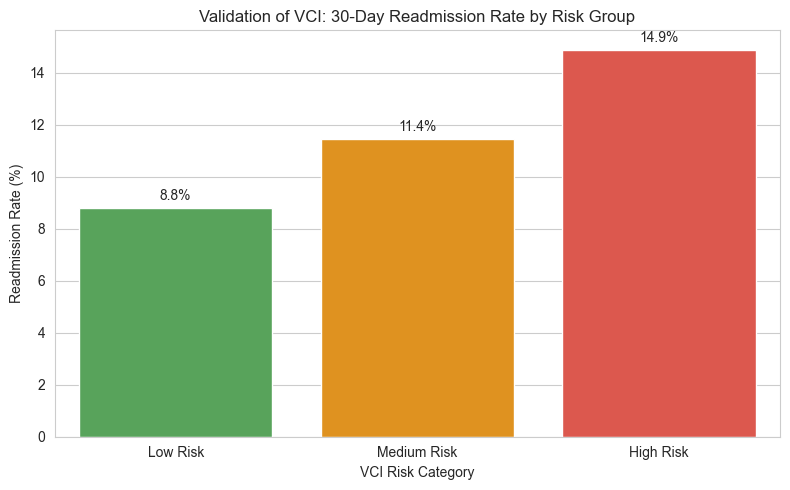


✓ Phase 4 complete. VCI validated and visualization saved to reports/.


In [5]:
print("\n--- STARTING PHASE 4: VITALITY COMPLEXITY INDEX (VCI) ---")

# Configuration
DATA_PATH = "../data/processed/diabetic_data_phase2_enriched.csv"
REPORTS_DIR = "../reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

# Load Data (Reproducibility Guaranteed)
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("Phase 2 dataset not found. Run Phases 1–3 first.")

df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded: {df.shape}")

# Ensure numeric types for scoring
df["admission_type_id"] = pd.to_numeric(df["admission_type_id"], errors="coerce")
df["number_emergency"] = pd.to_numeric(df["number_emergency"], errors="coerce")

# VCI Scoring Functions (Modular & Testable)
def calculate_L_points(days):
    """L — Length of Stay"""
    if days < 1:
        return 0
    elif 1 <= days <= 4:
        return 1
    elif 5 <= days <= 13:
        return 4
    else:
        return 7  # >= 14 days

def calculate_A_points(admission_id):
    """A — Acuity of Admission"""
    return 3 if admission_id in [1, 7] else 0

def calculate_C_points(num_diagnoses):
    """C — Comorbidity Burden"""
    if num_diagnoses < 4:
        return 0
    elif 4 <= num_diagnoses <= 7:
        return 3
    else:
        return 5  # >= 8 diagnoses

def calculate_E_points(num_emergency):
    """E — Emergency Visit Intensity"""
    if num_emergency == 0:
        return 0
    elif 1 <= num_emergency <= 4:
        return 3
    else:
        return 5  # > 4 visits

def assign_risk_category(score):
    """Map VCI score to clinical risk tier"""
    if score < 7:
        return "Low Risk"
    elif 7 <= score <= 10:
        return "Medium Risk"
    else:
        return "High Risk"

# Apply VCI Framework
print("Calculating VCI components...")

df["L_points"] = df["time_in_hospital"].apply(calculate_L_points)
df["A_points"] = df["admission_type_id"].apply(calculate_A_points)
df["C_points"] = df["number_diagnoses"].apply(calculate_C_points)
df["E_points"] = df["number_emergency"].apply(calculate_E_points)

df["VCI_Score"] = (
    df["L_points"]
    + df["A_points"]
    + df["C_points"]
    + df["E_points"]
)

df["VCI_Risk_Category"] = df["VCI_Score"].apply(assign_risk_category)

# Distribution Check
print("\nVCI Risk Category Distribution:")
print(df["VCI_Risk_Category"].value_counts(normalize=True).round(3))

# Validation: Readmission Rate by Risk Tier
validation = (
    df.groupby("VCI_Risk_Category")["readmitted"]
      .value_counts(normalize=True)
      .unstack()
)

validation["Readmission Rate (<30)"] = validation["<30"] * 100
validation = validation.loc[["Low Risk", "Medium Risk", "High Risk"]]

# Visualization (Saved Artifact)
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

sns.barplot(
    x=validation.index,
    y=validation["Readmission Rate (<30)"],
    palette=["#4CAF50", "#FF9800", "#F44336"],
    errorbar=None
)

plt.title("Validation of VCI: 30-Day Readmission Rate by Risk Group")
plt.ylabel("Readmission Rate (%)")
plt.xlabel("VCI Risk Category")

for i, v in enumerate(validation["Readmission Rate (<30)"]):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.savefig(os.path.join(REPORTS_DIR, "10_vci_readmission_validation.png"), dpi=300)
print("--- Validation of VCI: 30-Day Readmission Rate by Risk Group ---")
plt.show()

print("\n✓ Phase 4 complete. VCI validated and visualization saved to reports/.")
